# &#x1F4D1; &nbsp; $\mathfrak {\color{slategrey} { P3: \ Creating \ Customer \ Segments }}$

## $\mathfrak {\color{slategrey} {1. \ References}}$
### Dataset
In this project, we will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

### Resources
Scikit-learn: http://scikit-learn.org/stable/index.html

Seaborn: http://seaborn.pydata.org/index.html

## $\mathfrak {\color{slategrey} {2.\ Code \ Library}}$

In [1]:
from IPython.core.display import HTML
hide_code = ''
HTML('''<script>code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    }
    code_show = !code_show;
} 
$(document).ready(code_display);</script>
<form action="javascript: code_display()"><input style="color: slategrey; background: ghostwhite; opacity: 0.9; " \
type="submit" value="Click to display or hide code"></form>''')

In [3]:
hide_code
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import pylab as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

################################
### ADD EXTRA LIBRARIES HERE ###
################################

import warnings
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

## $\mathfrak {\color{slategrey} { 3. \ Data \ Exploration}}$
In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. We will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

The dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products we could purchase.
### 3.1 Data Loading

In [4]:
hide_code
# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print ("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

# Display a description of the dataset
display(data.describe())

Wholesale customers dataset has 440 samples with 6 features each.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [16]:
print(plt.style.available)

['ggplot', 'seaborn-white', 'grayscale', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-bright', 'dark_background', 'classic', 'seaborn-talk', 'seaborn-deep', 'seaborn-muted', 'seaborn-poster', 'fivethirtyeight', 'seaborn-ticks', 'seaborn-darkgrid', 'bmh', 'seaborn-paper', 'seaborn-colorblind', 'seaborn-whitegrid', 'seaborn-pastel', 'seaborn-notebook']


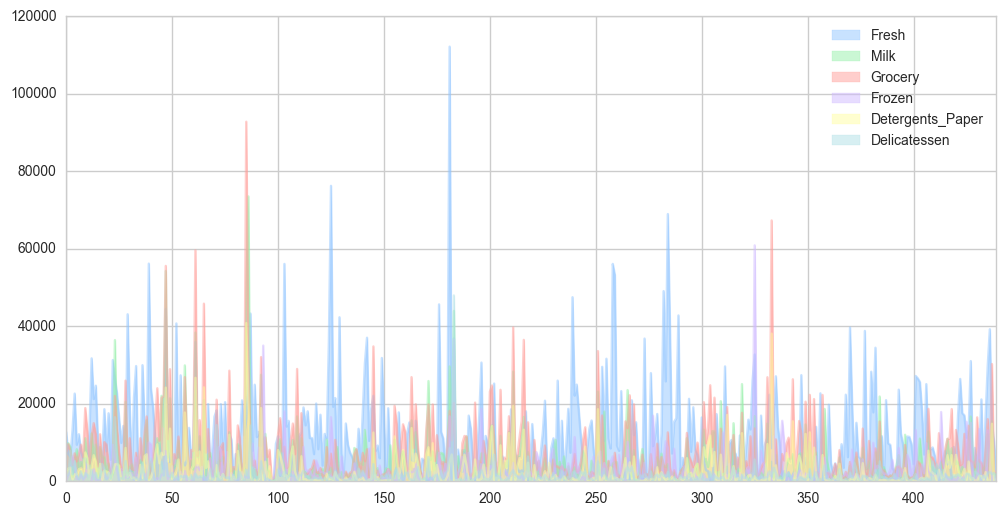

In [7]:
hide_code
plt.style.use('seaborn-whitegrid')
data.plot.area(stacked=False, figsize=(12,6))

### 3.2 Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [8]:
hide_code
# Select three indices of your choice you wish to sample from the dataset
indices = [109,262,347]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print ("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1406,16729,28986,673,836,3
1,23257,1372,1677,982,429,655
2,27380,7184,12311,2809,4621,1022


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
### Answer 1


### 3.3 Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, we will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of our choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as our target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

##### Experiment with the Feature 'Frozen'

In [9]:
hide_code
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Frozen', axis = 1)
target = data['Frozen']
new_data_target = pd.concat([new_data, target], axis = 1)
# Display the correlation table for the given feature
print ("The correlation table for the choosen feature 'Frozen'")
pearson = new_data_target.corr(method='pearson')
corr_with_delicatessen = pearson.ix[-1][:-1]
corr_with_delicatessen[abs(corr_with_delicatessen).argsort()[::-1]]

The correlation table for the choosen feature 'Frozen'


Delicatessen        0.390947
Fresh               0.345881
Detergents_Paper   -0.131525
Milk                0.123994
Grocery            -0.040193
Name: Frozen, dtype: float64

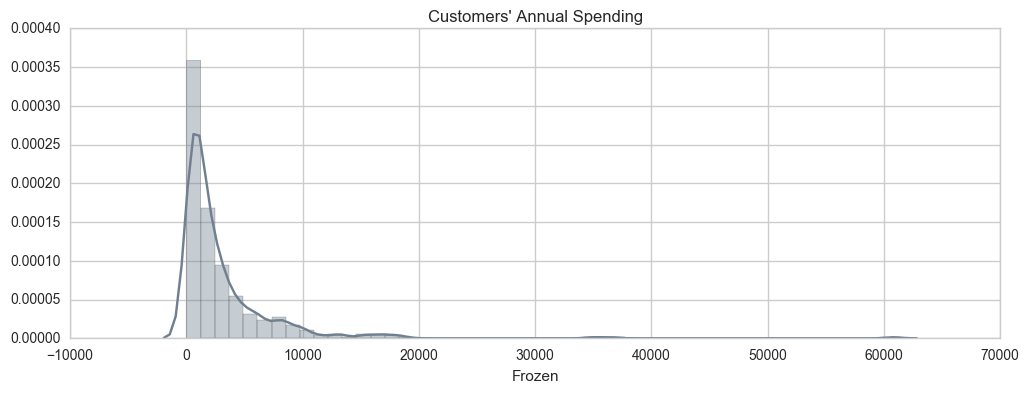

In [10]:
hide_code
warnings.filterwarnings('ignore')
plt.style.use('seaborn-bright')
plt.figure(figsize=(12,4))
sns.distplot(target, color='slategrey')
plt.xlabel("Frozen")
plt.title("Customers' Annual Spending")

In [11]:
hide_code
# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size = 0.25, random_state = 1)

# Success
print ("Training and testing split was successful.")

# Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print("The score of the prediction using the testing set is {}.".format(score))

Training and testing split was successful.
The score of the prediction using the testing set is -0.6495743273336552.


##### Experiment with the Feature 'Grocery'

In [12]:
hide_code
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Grocery', axis = 1)
target = data['Grocery']
new_data_target = pd.concat([new_data, target], axis = 1)
# Display the correlation table for the given feature
print ("The correlation table for the choosen feature 'Grocery'")
pearson = new_data_target.corr(method='pearson')
corr_with_delicatessen = pearson.ix[-1][:-1]
corr_with_delicatessen[abs(corr_with_delicatessen).argsort()[::-1]]

The correlation table for the choosen feature 'Grocery'


Detergents_Paper    0.924641
Milk                0.728335
Delicatessen        0.205497
Frozen             -0.040193
Fresh              -0.011854
Name: Grocery, dtype: float64

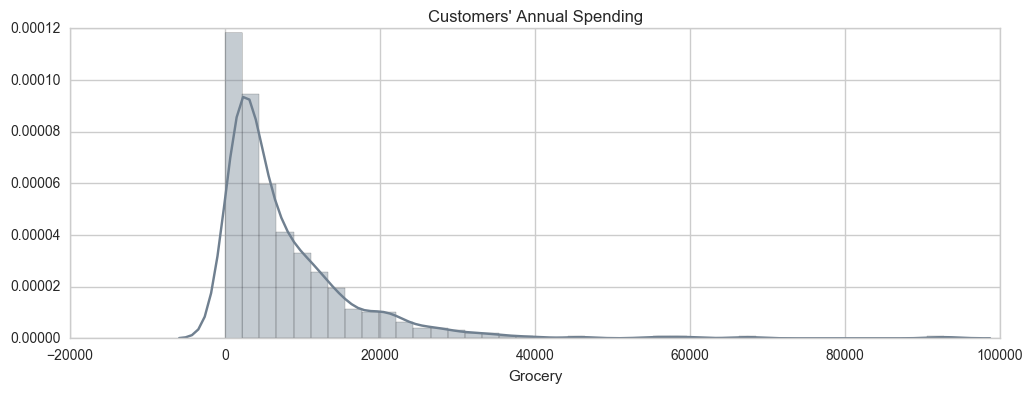

In [13]:
hide_code
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,4))
sns.distplot(target, color='slategrey')
plt.xlabel("Grocery")
plt.title("Customers' Annual Spending")

In [14]:
hide_code
# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size = 0.25, random_state = 1)

# Success
print ("Training and testing split was successful.")

# Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print("The score of the prediction using the testing set is {}.".format(score))

Training and testing split was successful.
The score of the prediction using the testing set is 0.7957683115761958.


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
### Answer 2

### 3.4 Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If we found that the feature we attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if we believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. 

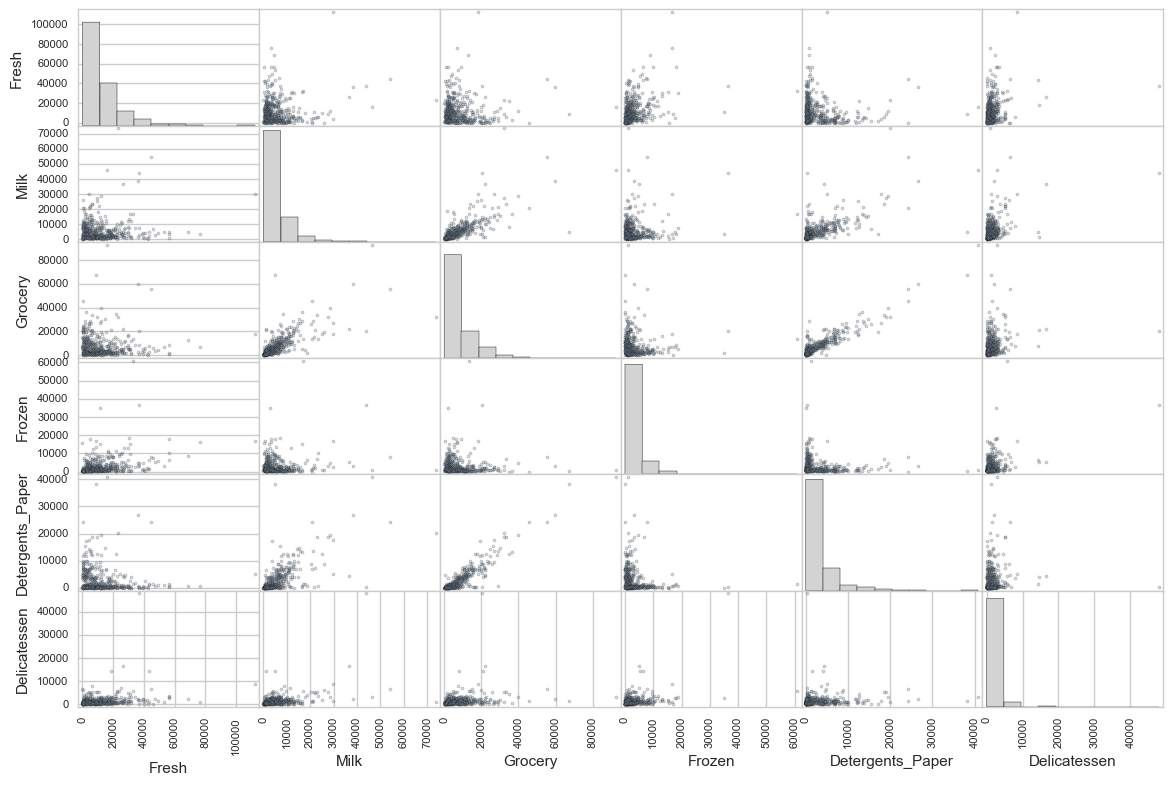

In [32]:
hide_code
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,9), diagonal = 'hist', 
                  c="SlateGrey", hist_kwds={'color':'LightGrey'});

In [36]:
hide_code
pearson = data.corr(method='pearson')
print ("Pearson correlation coefficients")
pearson

Pearson correlation coefficients


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?* 
### Answer 3

## $\mathfrak {\color{slategrey} { 4. \ Data \ Preprocessing}}$
In this section, we will preprocessing the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### 4.1 Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

Now we will do the following steps:

 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

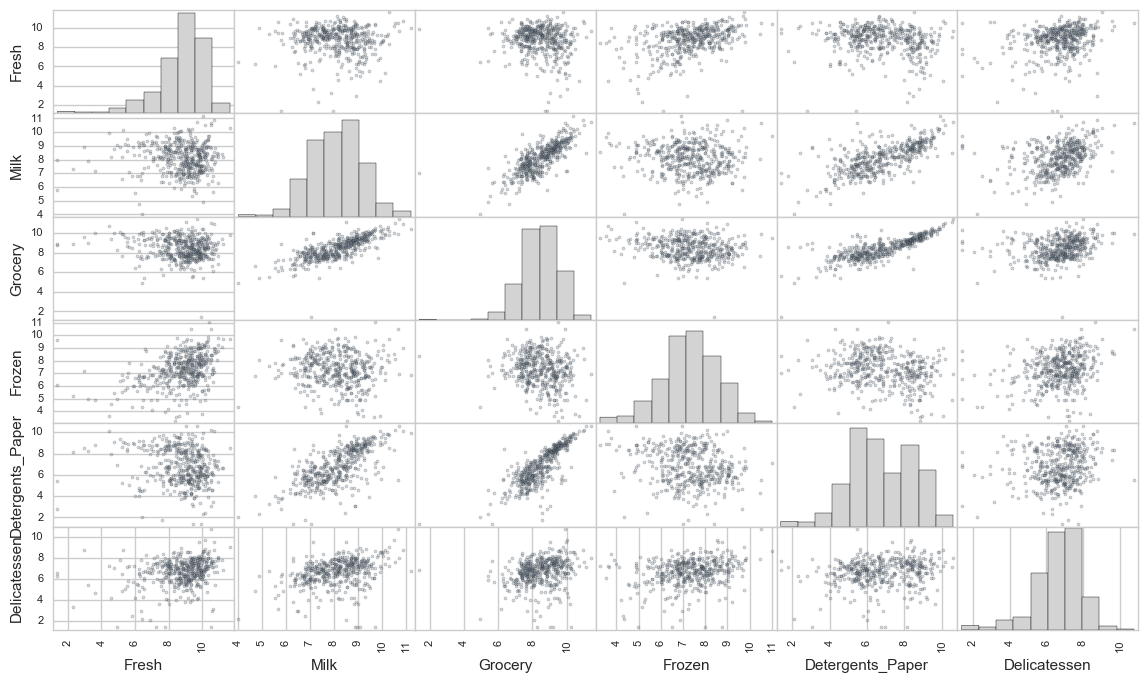

In [31]:
hide_code
# Scale the data using the natural logarithm
log_data = data.apply(lambda x: np.log(x + 1))

# Scale the sample data using the natural logarithm
log_samples = samples.apply(lambda x: np.log(x + 1))

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'hist', 
                  c="SlateGrey", hist_kwds={'color':'LightGrey'});

### 4.2 Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features we may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

In [33]:
hide_code
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294
1,10.054404,7.224753,7.425358,6.890609,6.063785,6.486161
2,10.217605,8.879751,9.418330,7.940940,8.438583,6.930495


In [37]:
hide_code
pearson_log = log_data.corr(method='pearson')
print ("Pearson correlation coefficients")
pearson_log

Pearson correlation coefficients


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,-0.021096,-0.132989,0.386258,-0.158706,0.256442
Milk,-0.021096,1.000000,0.761128,-0.055229,0.678725,0.342310
Grocery,-0.132989,0.761128,1.000000,-0.164525,0.797141,0.239998
Frozen,0.386258,-0.055229,-0.164525,1.000000,-0.212771,0.256318
Detergents_Paper,-0.158706,0.678725,0.797141,-0.212771,1.000000,0.167573
Delicatessen,0.256442,0.342310,0.239998,0.256318,0.167573,1.000000


### 4.3 Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

So the next steps are the following:

 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.


In [ ]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = None
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = None
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = None
    
    # Display the outliers
    print ("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 
### Answer 4

## $\mathfrak {\color{slategrey} { 5. \ Feature \ Transformation}}$
In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### 5.1 PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

The next steps are the following:

 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [ ]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = None

# TODO: Transform log_samples using the PCA fit above
pca_samples = None

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
### Answer 5

### 5.2 PCA Observation
Let us have a look how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with our initial interpretation of the sample points.

In [ ]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

### 5.3 Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

The next steps are the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [ ]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = None

# TODO: Transform the good data using the PCA fit above
reduced_data = None

# TODO: Transform log_samples using the PCA fit above
pca_samples = None

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### 5.4 Dimensionality Reduction Observation
Let's see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [ ]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

## $\mathfrak {\color{slategrey} { 6. \ Visualizing \ a \ Biplot}}$
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

In [ ]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### 6.1 Observation
Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot we obtained earlier?

## $\mathfrak {\color{slategrey} { 7. \ Clustering}}$

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*
### Answer 6

### 7.1 Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

Now we need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [ ]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = None

# TODO: Predict the cluster for each data point
preds = None

# TODO: Find the cluster centers
centers = None

# TODO: Predict the cluster for each transformed sample data point
sample_preds = None

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = None

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 
### Answer 7

### 7.2 Cluster Visualization
Once we've chosen the optimal number of clusters for the clustering algorithm using the scoring metric above, we can now visualize the results. Note that, for experimentation purposes, it's useful to adjust the number of clusters for the clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters.

In [ ]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### 7.3 Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

It's time for the next steps:

 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.

In [ ]:
# TODO: Inverse transform the centers
log_centers = None

# TODO: Exponentiate the centers
true_centers = None

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
### Answer 8

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*


In [ ]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print ("Sample point", i, "predicted to be in Cluster", pred)

### Answer 9

## $\mathfrak {\color{slategrey} { 8. \ Conclusion}}$
In this final section, we will investigate ways that we can make use of the clustered data. First, we will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, we will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, we will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

*How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
### Answer 10

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  

*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
### Answer 11

### 8.1 Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Let's see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, we will find the sample points are circled in the plot, which will identify their labeling.

In [ ]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*
### Answer 12

### 8.2 Reflections